In [4]:
from IPython.display import display, Image

# Emotions From Images: Convolutional Neural Network with CNTK

This notebook is based and much information is from the CNTK tutorial [here](https://cntk.ai/pythondocs/CNTK_103D_MNIST_ConvolutionalNeuralNetwork.html).

In this tutorial we will train a Convolutional Neural Network (CNN) on facial expression image data. This notebook provides the recipe using the Python API.

**Problem**:
In this exercise we will work with an emotions dataset, comprising of grayscale images of either happy or sad faces. 

In [6]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

%matplotlib inline

**Data Format** The data is stored on our local machine in the CNTK CTF format.  The CTF format is a simple text format that contains a set of samples with each sample containing a set of named fields and their data.  For MNIST data, each sample contains 2 fields: labels and feature, formatted as:

    |labels 0 0 0 1 0 0 0 0 0 0 |features 0 255 0 123 ... 
                                                  (784 integers each representing a pixel gray level)
    
In this tutorial we are going to use the image pixels corresponding to the integer stream named "features". We define a `create_reader` function to read the training and test data using the [CTF deserializer](https://cntk.ai/pythondocs/cntk.io.html#cntk.io.CTFDeserializer). . 

The labels are [1-hot](https://en.wikipedia.org/wiki/One-hot) encoded (the label representing the output class of 3  becomes `0001000000` since we have 10 classes for the 10 possible digits), where the first index corresponds to digit `0` and the last one corresponds to digit `9`.

![mnist-label](https://www.cntk.ai/jup/cntk103a_onehot.png)

In [7]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    
    ctf = C.io.CTFDeserializer(path, C.io.StreamDefs(
          labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
          features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)))
                          
    return C.io.MinibatchSource(ctf,
        randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [8]:
# Ensure the training and test data is available for this tutorial.
# We search in two locations in the toolkit for the cached MNIST data set.

data_found=False # A flag to indicate if train/test data found in local cache
for data_dir in [os.path.join(os.path.sep + "data")]:
    
    train_file=os.path.join(data_dir, "Emotions-48x48-train_cntk_text.txt")
    test_file=os.path.join(data_dir, "Emotions-48x48-test_cntk_text.txt")
    
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found=True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
    
print("Data directory is {0}".format(data_dir))

Data directory is /data


In [9]:
print(test_file)

/data/Emotions-48x48-test_cntk_text.txt


## Building our CNN models

In [12]:
# Build a basic 3-layer CNN with the layers module 
# Ref:  https://cntk.ai/pythondocs/layerref.html

# def create_model(features):
#     with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
#             h = features
#             h = C.layers.Convolution2D(filter_shape=(5,5), 
#                                        num_filters=8, 
#                                        strides=(2,2), 
#                                        pad=True, 
#                                        name='first_conv')(h)
#             h = C.layers.Convolution2D(filter_shape=(5,5),
#                                        num_filters=16,
#                                        strides=(1,1), 
#                                        pad=True, 
#                                        name='second_conv')(h)
#             h = C.layers.Convolution2D(filter_shape=(5,5), 
#                                        num_filters=16,
#                                        strides=(2,2), 
#                                        pad=True, 
#                                        name='thrid_conv')(h)
#             r = C.layers.Dense(num_output_classes, 
#                                activation=None, 
#                                name='classify')(h)
#             return r

In [13]:
# Build a CNN with pooling with the layers module 
# Ref:  https://cntk.ai/pythondocs/layerref.html#maxpooling-averagepooling

# def create_model(features):
#     with C.layers.default_options(init=C.glorot_uniform(), activation=C.leaky_relu):
#             h = features
#             h = C.layers.Convolution2D(filter_shape=(5,5), # shape of receptive field
#                                        num_filters=8, 
#                                        strides=(1,1), 
#                                        pad=True, name='first_conv')(h)
#             h = C.layers.AveragePooling(filter_shape=(2,2),   
#                            strides=1,
#                            pad=True,
#                            name='first_pooling')(h)
#             h = C.layers.Convolution2D(filter_shape=(5,5),
#                                        num_filters=16,
#                                        strides=(1,1), 
#                                        pad=True, name='second_conv')(h)
#             h = C.layers.MaxPooling(filter_shape=(2,2),
#                            strides=1,
#                            pad=True,
#                            name='second_pooling')(h)
#             h = C.layers.Convolution2D(filter_shape=(5,5), 
#                                        num_filters=16,
#                                        strides=(2,2), 
#                                        pad=True, name='third_conv')(h)
#             h = C.layers.MaxPooling(filter_shape=(2,2),
#                            strides=1,
#                            pad=True,
#                            name='third_pooling')(h)
#             r = C.layers.Dense(num_output_classes, activation=None, 
#                                name='classify')(h)
#             return r
        
# With MaxPooling as the first pooling layer:  Average test error: 31.79%
# With AveragePooling as the first pooling layer:  Average test error: 30.23%

In [30]:
# Build a CNN with pooling with the layers module and using the Sequential shortcut
# Ref:  https://cntk.ai/pythondocs/layerref.html#maxpooling-averagepooling

# def create_model(features):
#     with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
#         model = C.layers.Sequential([
#             C.layers.For(range(3), lambda i: [
#                 C.layers.Convolution2D(filter_shape=(5,5), 
#                                      num_filters=[8, 16, 16][i], 
#                                      pad=True, 
#                                      strides=[(1,1), (1,1), (2,2)][i]),
#                 C.layers.AveragePooling(filter_shape=(2,2),
#                                     strides=1, 
#                                     pad=True)
#                 ]),
#             C.layers.Dense(num_output_classes, activation=None)
#         ])
#     return model(features)

# Training took 1494.3 sec
# Average test error: 28.53% with all pooling being Average Pooling

# def create_model(features):

#     with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
#         model = C.layers.Sequential([
#             C.layers.For(range(3), lambda i: [
#                 C.layers.Convolution2D(filter_shape=(5,5), 
#                                      num_filters=[16, 32, 32][i], 
#                                      pad=True, 
#                                      strides=[(1,1), (1,1), (1,1)][i]),
#                 C.layers.MaxPooling(filter_shape=(2,2), # 3,3 pooling shape gave 26.9% with conv_third of 1,1 stride
#                                     strides=1, 
#                                     pad=True)
#                 ]),
#             C.layers.Dense(num_output_classes, activation=None)
#         ])
#     return model(features)

# Training took 5239.7 sec
# Average test error: 25.41%


def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
        model = C.layers.Sequential([
            C.layers.For(range(3), lambda i: [
                C.layers.Convolution2D(filter_shape=(5,5), 
                                     num_filters=[48, 48, 64][i], 
                                     pad=True, 
                                     strides=(1,1),
                C.layers.MaxPooling(filter_shape=(2,2),
                                    strides=1, 
                                    pad=True)
                ]),
            C.layers.Dense(256),
            C.layers.Dropout(0.5),
            C.layers.Dense(128),
            C.layers.Dropout(0.5),
            C.layers.Dense(num_output_classes, activation=None)
        ])
    return model(features)
            
# 3,3 pooling shape gave 26.9% with conv_third of 1,1 stride
# third stride is 2,2:
# Training took 12794.1 sec
# Average test error: 24.52%

# third stride is 1,1
# Training took 9812.6 sec
# Average test error: 22.35%
    
# Based on https://arxiv.org/pdf/1706.01509.pdf


## Training

Similar to CNTK 102, we minimize the cross-entropy between the label and predicted probability by the network. If this terminology sounds strange to you, please refer to the CNTK 102 for a refresher. Since we are going to build more than one model, we will create a few helper functions.

In [31]:
def create_criterion_function(model, labels):
    loss = C.cross_entropy_with_softmax(model, labels)
    errs = C.classification_error(model, labels)
    return loss, errs # (model, labels) -> (loss, error metric)

Next we will need a helper function to perform the model training. First let us create additional helper functions that will be needed to visualize different functions associated with training.

In [32]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

### Configure training

In the previous tutorials we have described the concepts of `loss` function, the optimizers or [learners](https://cntk.ai/pythondocs/cntk.learners.html) and the associated machinery needed to train a model. Please refer to earlier tutorials for gaining familiarility with these concepts. In this tutorial, we combine model training and testing in a helper function below. 


In [33]:
# Define the data dimensions
height = width = 48
input_dim_model = (1, height, width)    # images are 28 x 28 with 1 channel of color (gray)
input_dim = height*width*1                # used by readers to treat input data as a vector
num_output_classes = 2

x = C.input_variable(input_dim_model)
y = C.input_variable(num_output_classes)

# Initialize the parameters for the trainer
minibatch_size = 128
num_samples_per_sweep = 13559

learning_rate = 0.02

# Uncomment below for more detailed logging
training_progress_output_freq = 50

# Test data for trained model
test_minibatch_size = 64
num_samples = 1507

# Create the model
z = create_model(x)

# Number of parameters in the network
print(C.logging.log_number_of_parameters(z))

# # Print the output shapes / parameters of different components
# print("Output Shape of the first convolution layer:", z.first_conv.shape)
# print("Bias value of the last dense layer:", z.classify.b.value)

Training 37917906 parameters in 12 parameter tensors.
None


In [34]:
def do_train(train_reader, model_func, num_sweeps_to_train_with=10):
    
    # Instantiate the model function; x is the input (feature) variable 
    # We will scale the input image pixels within 0-1 range by dividing all input value by 255.
    model = model_func(x/255)
    
    # Instantiate the loss and error function
    loss, label_error = create_criterion_function(model, y)
    
    # Instantiate the trainer object to drive the model training
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    learner = C.sgd(z.parameters, lr_schedule)
    trainer = C.Trainer(z, (loss, label_error), [learner])

    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
    
    # Map the data streams to the input and labels.
    input_map={
        y  : train_reader.streams.labels,
        x  : train_reader.streams.features
    }
     
    # Start a timer
    start = time.time()

    for i in range(0, int(num_minibatches_to_train)):
        # Read a mini batch from the training data file
        data = train_reader.next_minibatch(minibatch_size, input_map=input_map) 
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
     
    # Print training time
    print("Training took {:.1f} sec".format(time.time() - start))

    
def do_test(test_reader, model_func):
    # Test the model

    model = model_func(x/255)
  
    loss, label_error = create_criterion_function(model, y)

    # Instantiate the trainer object to drive the model training
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    learner = C.sgd(z.parameters, lr_schedule)
    trainer = C.Trainer(z, (loss, label_error), [learner])
    
    test_input_map = {
        y  : test_reader.streams.labels,
        x  : test_reader.streams.features
    }

    num_minibatches_to_test = num_samples // test_minibatch_size

    test_result = 0.0


    for i in range(num_minibatches_to_test):
    
        # We are loading test data in batches specified by test_minibatch_size
        # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
        # with one pixel per dimension that we will encode / decode with the 
        # trained model.
        data = test_reader.next_minibatch(test_minibatch_size, input_map=test_input_map)
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

<a id='#Run the trainer'></a>
### Run the trainer and test model

We are now ready to train our convolutional neural net. 

In [35]:
reader_train = create_reader(train_file, True, input_dim, num_output_classes)
do_train(reader_train, z)
reader_test = create_reader(test_file, False, input_dim, num_output_classes)
do_test(reader_test, z)

Minibatch: 0, Loss: 0.7007, Error: 53.91%
Minibatch: 50, Loss: 0.6966, Error: 44.53%
Minibatch: 100, Loss: 0.6851, Error: 44.53%
Minibatch: 150, Loss: 0.6883, Error: 44.53%
Minibatch: 200, Loss: 0.6482, Error: 37.50%
Minibatch: 250, Loss: 0.6340, Error: 36.72%
Minibatch: 300, Loss: 0.6110, Error: 30.47%
Minibatch: 350, Loss: 0.6312, Error: 41.41%
Minibatch: 400, Loss: 0.5706, Error: 25.78%
Minibatch: 450, Loss: 0.6528, Error: 32.81%
Minibatch: 500, Loss: 0.5372, Error: 29.69%
Minibatch: 550, Loss: 0.5035, Error: 25.00%
Minibatch: 600, Loss: 0.5371, Error: 28.12%
Minibatch: 650, Loss: 0.5166, Error: 25.78%
Minibatch: 700, Loss: 0.5583, Error: 29.69%
Minibatch: 750, Loss: 0.4932, Error: 27.34%
Minibatch: 800, Loss: 0.4999, Error: 14.84%
Minibatch: 850, Loss: 0.4959, Error: 23.44%
Minibatch: 900, Loss: 0.5125, Error: 31.25%
Minibatch: 950, Loss: 0.4189, Error: 20.31%
Minibatch: 1000, Loss: 0.4281, Error: 23.44%
Minibatch: 1050, Loss: 0.5238, Error: 32.81%
Training took 9812.6 sec
Average 

In [36]:
z.save('/data/cnn_maxpool_dropout_emotions.model')

Note, the average test error is very comparable to our training error indicating that our model has good "out of sample" error a.k.a. [generalization error](https://en.wikipedia.org/wiki/Generalization_error). This implies that our model can very effectively deal with previously unseen observations (during the training process). This is key to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting).

Let us check what is the value of some of the network parameters. We will check the bias value of the output dense layer. Previously, it was all 0. Now you see there are non-zero values, indicating that a model parameters were updated during training.

In [ ]:
print("Bias value of the last dense layer:", z.classify.b.value)

## Evaluation / Prediction
We have so far been dealing with aggregate measures of error. Let us now get the probabilities associated with individual data points. For each observation, the `eval` function returns the probability distribution across all the classes. The classifier is trained to recognize digits, hence has 10 classes. First let us route the network output through a `softmax` function. This maps the aggregated activations across the network to probabilities across the 10 classes.

In [38]:
out = C.softmax(z)

Let us a small minibatch sample from the test data.

In [82]:
# Read the data for evaluation
reader_eval=create_reader('/data/harris_48x48_cntk_text.txt', False, input_dim, num_output_classes)
# reader_eval=create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 2
eval_input_map = {x: reader_eval.streams.features, y:reader_eval.streams.labels} 

data = reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

img_label = data[y].asarray()
img_data = data[x].asarray()

# reshape img_data to: M x 1 x 28 x 28 to be compatible with model
img_data = np.reshape(img_data, (eval_minibatch_size, 1, 48, 48))

predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

In [83]:
# Find the index with the maximum value for both predicted as well as the ground truth
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [84]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [0, 1]
Predicted: [0, 1]


Let us visualize some of the results

Image Label:  0


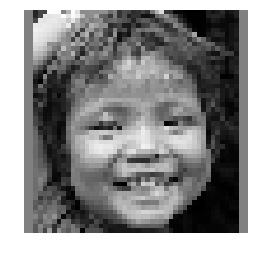

In [85]:
# Plot a random image
sample_number = 0
plt.imshow(img_data[sample_number].reshape(48,48)/255,
           interpolation='nearest',
           cmap="gray")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)